601288
股票代码： 601288 消极比例： 0.099644128113879 积极比例： 0.900355871886121
600332
股票代码： 600332 消极比例： 0.21071428571428572 积极比例： 0.7892857142857143


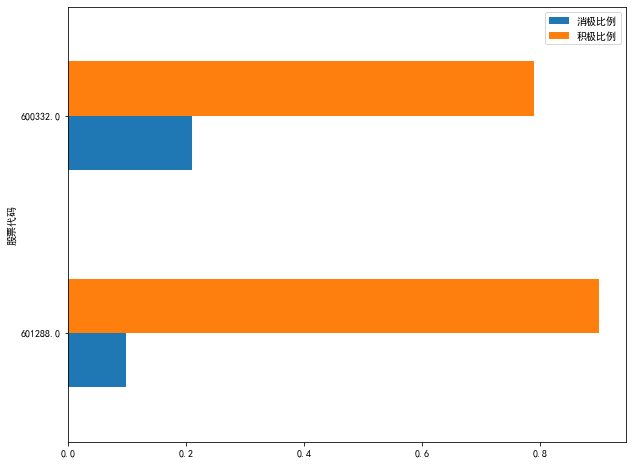

In [2]:
# 【0】股票舆情分析系统: pip install baidu-aip + 登录并注册百度人工智能平台（https://ai.baidu.com/）
'''
在获取了股票的新闻数据之后，我们接下来需要对每支股票的所有新闻进行情感分析了。其中用到了百度人工智能接口aip下的
aipNLP 用于对所有新闻数据进行自然语言处理，并进行情感分析。需要注意的是，在通过百度人工智能接口进行情感分析之前
需要先注册并获取APP_ID、API_KEY以及SECRET_KEY。获取的方式如下：
    首先，登录并注册百度人工智能平台（https://ai.baidu.com/）：
    然后，在自己的控制台中找到自然语言处理，并创建应用，如下图所示：
    创建完成之后就可以得到自己的APP_ID、API_KEY以及SECRET_KEY，如下图所示：
'''
import os
import re
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from lxml import etree
from aip import AipNlp

desktop_path = os.path.join(os.path.expanduser("~"), 'Desktop','stocks.csv')
desk = os.path.join(os.path.expanduser("~"), 'Desktop')
# print(desktop_path)
# ———————————————————— 获取url下的最大page数
def get_max_page(url):
    page_data = requests.get(url).content.decode("gbk")
    data_tree = etree.HTML(page_data)
    if page_data.find("page_newslib"):
        max_page = data_tree.xpath("//*[@class=\"page_newslib\"]//a[last()-1]/text()")
        return int(max_page[0])
    else:
        return 1

# ———————————————————— 解析指定页面的数据并保存至本地
def download_page(url, code):
    try:
        page_data = requests.get(url).content.decode("gbk")
        data_tree = etree.HTML(page_data)
        titles = data_tree.xpath("//*[@class = \"newlist\"]//li/span/a/text()")
        for title in titles:
            title = title + "\r\n"
            with open(desk+"\\"+str(code) + ".txt", "a") as file:
                file.write(title)
                file.flush()
        return
    except:
        print("服务器超时")

# ———————————————————— 解析每个页面的数据
def parse_pages(url, code):
    max_page = get_max_page(url)
    for i in range(1, max_page + 1):
        if i != 1:
            url = "http://stock.jrj.com.cn/share," + str(code) + ",ggxw_" + str(i) + ".shtml"
        download_page(url, code)
# ******* ———————————————————— 下载指定的股票的新闻数据 *******
def download_news(codes):
    for code in codes:
        print(code)
        url = "http://stock.jrj.com.cn/share," + str(code) + ",ggxw.shtml"
        parse_pages(url, code)
# *******———————————————————— 对指定的股票进行情感分析并保存到本地*******
def analyze_stocks(codes):
    df = pd.DataFrame()
    for code in codes:
        print(code)
        stock_dict = analyze(code)
        df = df.append(stock_dict, ignore_index=True)
    df.to_csv(desktop_path)
# ———————————————————— 对指定股票的所有新闻数据进行情感分析并进行统计
def analyze(code):
    APP_ID = '24171780'
    API_KEY = 'IQDRbYZ7OwEWY7EGrPUtyV96'
    SECRET_KEY = 'pyfSSOcMQPLaIIl9KGIW3nLstfTSjo4X'
    positive_nums = 0
    nagative_nums = 0
    count = 0
    aipNlp = AipNlp(APP_ID, API_KEY, SECRET_KEY)
    lines = open(desk+"\\"+str(code) + '.txt').readlines()
    for line in lines:
        if not line.isspace():
            line = line.strip()
            try:
                result = aipNlp.sentimentClassify(line)
                positive_prob = result['items'][0]['positive_prob']
                nagative_prob = result['items'][0]['negative_prob']
                count += 1
                if positive_prob >= nagative_prob:
                    positive_nums += 1
                else:
                    nagative_nums += 1
            except:
                pass
    avg_positive = positive_nums / count
    avg_nagative = nagative_nums / count
    print('股票代码：',code, '消极比例：', avg_nagative, '积极比例：',avg_positive)
    return {'股票代码':code, '消极比例':avg_nagative, '积极比例':avg_positive}

def show():
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False
    df = pd.read_csv(desktop_path, index_col='股票代码', usecols=['股票代码', '消极比例','积极比例'])
    df.plot(kind='barh', figsize=(10, 8))
    plt.show()

if __name__ == '__main__':
#     codes = [601288, 600332]
#     download_news(codes)
    analyze_stocks(codes)
    show()
